# Projekt: Bild-Klassifikator für eigene Objekte

In [2]:
# Import Libraries
# import libraries
# from tensorflow.keras.applications.vgg16 import VGG16, decode_predictions, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image # Keras own inbuild image class
from tensorflow.keras.layers import Dense,Dropout,GlobalAveragePooling2D,Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import Sequential,Input,Model

import numpy as np
import matplotlib.pyplot as plt

## Phase 1: Datensammlung

Es wurden Bilder der Klassen Bottle, Cup, Keyboard und Pen gesammelt.
Im ersten Schritt wurden die Bilder mithilfe des [Normalize Notebook](normalize.ipynb) normalisiert, um ihre Größe lokal zu reduzieren und sie anschließend effizient auf GitHub hochzuladen.

## Phase 2: Datenverarbeitung & Exploration

- Bottle
- Cup
- Keyboard
- Pen

### Lade die Bilder und verschaffe dir einen Überblick:

In [3]:
img = image.load_img('dataset/train/bottle/IMG_2646.jpg')
type(img)

PIL.JpegImagePlugin.JpegImageFile

In [4]:
#convert image to array, can also specify datatype
img = image.img_to_array(img,dtype='uint8')

In [5]:
img.shape

(224, 224, 3)

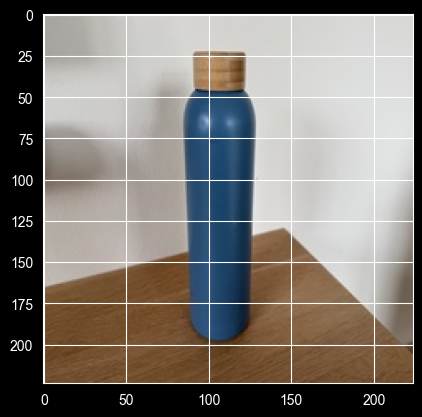

In [6]:
#plot image 
plt.imshow(img)

### Loading the entire images and labels

In [7]:
# Let's explore the data folder
import os
base_path = 'dataset/train/'

# Let's define the classes
classes = os.listdir(base_path)

In [8]:
 for class_ in classes:
        print(class_)

cup
pen
bottle
keyboard


In [9]:
def load_image(base_path):
    """it loads all the image into X and the classes in y """
    X_list = []
    y_list = []
    classes = os.listdir(base_path)
    for class_ in classes:
        if class_!='.DS_Store':
        
            files = os.listdir(base_path+class_)
            for file in files:
                pic = image.load_img(path=base_path+class_+'/'+f'{file}',target_size=(224,224))
                numpy_image = np.array(pic)
                processed_image = preprocess_input(numpy_image)
                X_list.append(processed_image)
                y_list.append(class_)

    X = np.array(X_list)
    y = np.array(y_list)
    
    return X, y, classes

In [10]:
X, y, classes= load_image(base_path)

In [11]:
X.shape

(280, 224, 224, 3)

In [12]:
y

array(['cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup',
       'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup',
       'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup',
       'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup',
       'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup',
       'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup',
       'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup',
       'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'pen', 'pen',
       'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen',
       'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen',
       'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen',
       'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen',
       'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen',
       'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen',
       'pen', 'pen',

## Implementiere Preprocessing:

In [13]:
X = preprocess_input(X)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


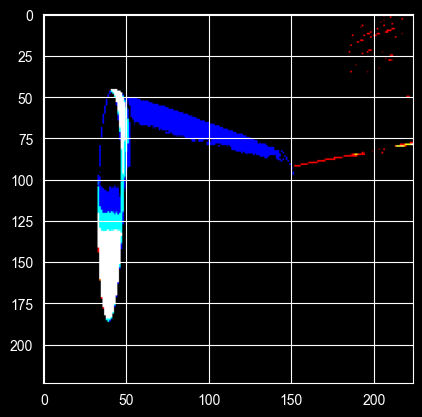

In [14]:
plt.imshow(X[0])

## Richte Data Augmentation ein:

In [15]:
# define an image data generator
# Data augmentation: Applies random distortions and transformations to the images (only on your training data!).

data_gen = image.ImageDataGenerator(
    # define the preprocessing function that should be applied to all images
    preprocessing_function=preprocess_input,
    # fill_mode='nearest',
    rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=(1.1, 1.2),
    # shear_range=0.2
)

In [16]:
# a generator that returns batches of X and y arrays
train_data_gen = data_gen.flow_from_directory(
        directory='dataset/train',
        class_mode="categorical",
        classes=classes,
        batch_size=300,
        target_size=(224, 224),
)

Found 280 images belonging to 4 classes.


In [17]:
train_data_gen.class_indices

{'cup': 0, 'pen': 1, 'bottle': 2, 'keyboard': 3}

In [18]:
train_data_gen.samples

280

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


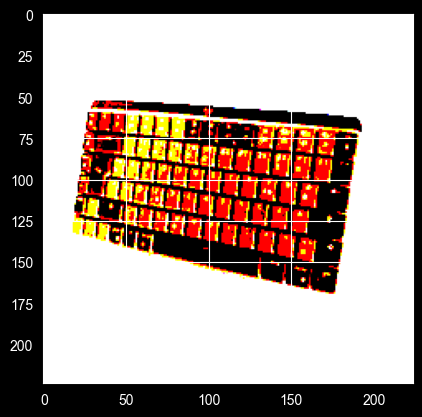

In [19]:
batch_bilder, batch_labels = train_data_gen[0]

image_to_show = batch_bilder[0]

plt.imshow(image_to_show)

In [20]:
val_data_gen = data_gen.flow_from_directory(
         directory='dataset/val/',
         class_mode="categorical",
         classes=classes,
         batch_size=150,
         target_size=(224, 224),
)

Found 60 images belonging to 4 classes.


## Phase 3: Modelltraining mit Transfer Learning

In [21]:
import tensorflow.keras.backend as K
K.clear_session()

#1. Select the convolutional base / Pretrained network
base_model = ResNet50(include_top=False)

In [22]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [23]:
#2. Freeze the weights in order to not retrain the loaded pre-trained model
#base_model.trainable= False

In [24]:
train_data_gen.image_shape

(224, 224, 3)

In [25]:
val_data_gen.image_shape

(224, 224, 3)

In [26]:
base_model.trainable = False

inputs = Input(shape=(224,224,3))
base = base_model(inputs)

# dont forget to flatten out before the final layer
flatten = Flatten()(base)

outputs = Dense(4,activation='softmax')(flatten)

model_tf = Model(inputs,outputs)

In [27]:
model_tf.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 4)                 401412    
                                                                 
Total params: 23989124 (91.51 MB)
Trainable params: 401412 (1.53 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [28]:

# 3. Kompilieren (Wir kompilieren jetzt 'model', NICHT 'base_model')
model_tf.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 4. Trainieren (Wir trainieren 'model')
history = model_tf.fit(train_data_gen,
                    verbose=2,
                    epochs=10,
                    validation_data=val_data_gen)

Epoch 1/10
1/1 - 12s - loss: 2.7708 - accuracy: 0.2714 - val_loss: 14.5020 - val_accuracy: 0.5667 - 12s/epoch - 12s/step
Epoch 2/10
1/1 - 8s - loss: 14.0785 - accuracy: 0.5750 - val_loss: 5.0585 - val_accuracy: 0.7500 - 8s/epoch - 8s/step
Epoch 3/10
1/1 - 8s - loss: 4.7720 - accuracy: 0.7571 - val_loss: 1.2122 - val_accuracy: 0.9167 - 8s/epoch - 8s/step
Epoch 4/10
1/1 - 8s - loss: 1.2321 - accuracy: 0.8750 - val_loss: 2.4790 - val_accuracy: 0.8167 - 8s/epoch - 8s/step
Epoch 5/10
1/1 - 8s - loss: 2.1646 - accuracy: 0.8250 - val_loss: 2.5197 - val_accuracy: 0.8000 - 8s/epoch - 8s/step
Epoch 6/10
1/1 - 8s - loss: 1.7632 - accuracy: 0.8429 - val_loss: 0.8049 - val_accuracy: 0.9333 - 8s/epoch - 8s/step
Epoch 7/10
1/1 - 8s - loss: 0.3246 - accuracy: 0.9429 - val_loss: 0.1442 - val_accuracy: 0.9833 - 8s/epoch - 8s/step
Epoch 8/10
1/1 - 8s - loss: 0.0233 - accuracy: 0.9964 - val_loss: 1.3112e-05 - val_accuracy: 1.0000 - 8s/epoch - 8s/step
Epoch 9/10
1/1 - 7s - loss: 1.4600e-05 - accuracy: 1.00

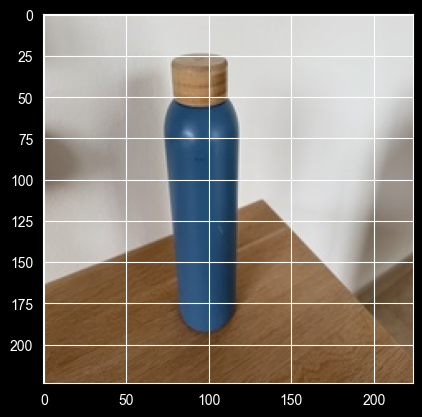

In [36]:

img = image.load_img('dataset/test/bottle/IMG_2647.jpg',target_size=(224,224))
img = image.img_to_array(img,dtype='uint8')
plt.imshow(img)

In [38]:
model_tf.predict(img)

ValueError: in user code:

    File "/Users/lucas/PycharmProjects/Bild-Klassifikation-Gruppe-1/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/Users/lucas/PycharmProjects/Bild-Klassifikation-Gruppe-1/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/lucas/PycharmProjects/Bild-Klassifikation-Gruppe-1/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/lucas/PycharmProjects/Bild-Klassifikation-Gruppe-1/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/Users/lucas/PycharmProjects/Bild-Klassifikation-Gruppe-1/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/lucas/PycharmProjects/Bild-Klassifikation-Gruppe-1/.venv/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(32, 224, 3)


# Wähle ein vortrainiertes Modell als Basis:

In [37]:
classes

['cup', 'pen', 'bottle', 'keyboard']

## Phase 4: Evaluation

## Phase 5: Testing mit neuen Bildern